<a href="https://colab.research.google.com/github/priyanbhatt/Testing-the-Generalization-Hypothesis-in-Deepfake-Detection/blob/main/efficientnet_new_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import pandas as pd
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.applications.resnet50 import preprocess_input
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Check for available GPUs and configure TensorFlow to use one
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Set the GPU to be used
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs
Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
BATCH_SIZE =128
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER = 7500

In [ ]:
def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary below.
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_png(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    label = tf.cast(example['label'], tf.int32)
    return image, label

def dataset_from_tfrecords(tfrecords_paths, batch_size=BATCH_SIZE, shuffle=False, shuffle_buffer=1024):
    if isinstance(tfrecords_paths, str):
        tfrecords_paths = [tfrecords_paths]

    if not tfrecords_paths:
        print("Warning: tfrecords_paths is empty, returning an empty dataset.")
        return tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))

    files_ds = tf.data.Dataset.from_tensor_slices(tfrecords_paths)
    if shuffle:
        files_ds = files_ds.shuffle(len(tfrecords_paths))

    ds = files_ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    # One-hot encode the labels
    # ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=2)), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

real_face_train="/content/drive/My Drive/Research Project/dataset/Real_Face/train.tfrecord"
stylegan2_train="/content/drive/My Drive/Research Project/dataset/Stylegan2/train.tfrecord"
new_faces_train="/content/drive/My Drive/Research Project/dataset/New_faces/train.tfrecord"
all_train_tfrecords = [real_face_train ,stylegan2_train,new_faces_train]


train_dataset = dataset_from_tfrecords(all_train_tfrecords, batch_size=BATCH_SIZE, shuffle=True)




real_face_test="/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord"
stylegan2_test="/content/drive/My Drive/Research Project/dataset/Stylegan2/test.tfrecord"
stylegan3_test="/content/drive/My Drive/Research Project/dataset/Stylegan3/test.tfrecord"
new_faces_test="/content/drive/My Drive/Research Project/dataset/New_faces/test.tfrecord"

all_test_tfrecords = [real_face_test,stylegan2_test,new_faces_test]

test_dataset = dataset_from_tfrecords(all_test_tfrecords, batch_size=BATCH_SIZE,shuffle=False)


print("Datasets are loaded from TFRecord shards, batched, prefetched, and cached.")

Datasets are loaded from TFRecord shards, batched, prefetched, and cached.


In [ ]:
initial_dataset = tf.data.TFRecordDataset(new_faces_train)
total_samples = sum(1 for _ in initial_dataset)
print(f"Total samples found: {total_samples}")

In [ ]:
initial_dataset = tf.data.TFRecordDataset(stylegan2_train)
total_samples = sum(1 for _ in initial_dataset)
print(f"Total samples found: {total_samples}")

In [ ]:
base_model=tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224,224,3))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable layers: {len([l for l in base_model.layers if l.trainable])}")

Total layers: 814
Trainable layers: 0


In [ ]:
base_model.summary()

Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)


# x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
# x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {len([l for l in model.layers if l.trainable])}")

Total layers: 8
Trainable layers: 7


In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=7,
    restore_best_weights=True
)
# reduce_lr=ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-8, monitor='loss')
model_checkpoint = ModelCheckpoint(
    filepath='best_model_24_1.keras',
    save_best_only=True,
    monitor='loss',
    mode='min',
    verbose=1
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(),
    #use categorical cross entropy with one hot encoded labels
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        81,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,180,329 (244.83 MB)

 Trainable params: 82,578 (322.57 KB)

 Non-trainable params: 64,097,751 (244.51 MB)

In [ ]:
history=model.fit(
    train_dataset,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/15
    128/Unknown 241s 1s/step - accuracy: 0.4626 - loss: 1.0181   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: loss improved from inf to 0.83988, saving model to best_model_24_1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4632 - loss: 1.0167
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6352 - loss: 0.6539
Epoch 2: loss improved from 0.83988 to 0.79558, saving model to best_model_24_1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 113s 874ms/step - accuracy: 0.6346 - loss: 0.6550
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.6548 - loss: 0.6361
Epoch 3: loss improved from 0.79558 to 0.76872, saving model to best_model_24_1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 115s 892ms/step - accuracy: 0.6542 - loss: 0.6371
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.4829 - loss: 0.9357
Epoch 4: loss improved from 0.76872 to 0.74073, saving model to best_model_24_1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 112s 871ms/step - accuracy: 0.4838 - loss: 0.9342
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.7210 - loss: 0

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/rp/efficientnet/efficient_net_new_10-12_1.keras')
model.save('/content/drive/MyDrive/Colab Notebooks/rp/efficientnet/efficient_net_new_10-12_1.h5')

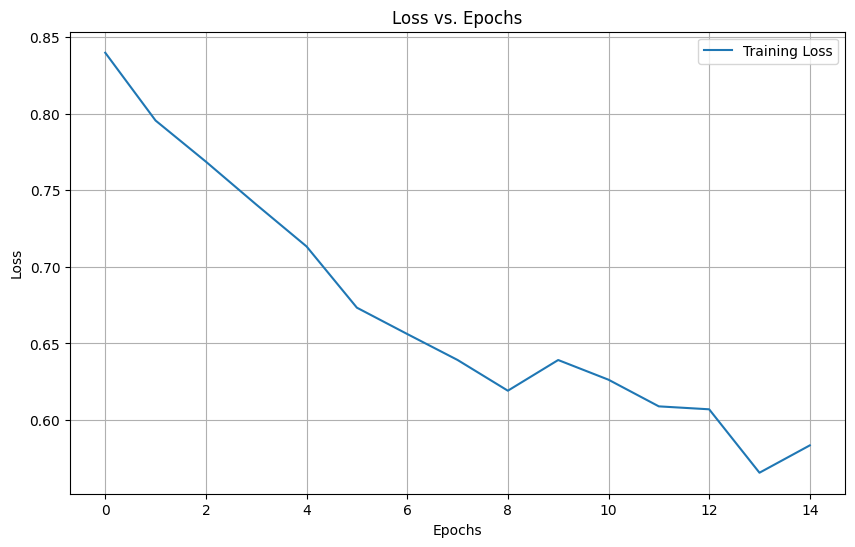

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test Binary Accuracy: {binary_accuracy:.4f}")

# Generate predictions for the test dataset
y_pred_probs = model.predict(test_dataset)

39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7553 - loss: 0.5281
Test Loss: 0.3873
Test Accuracy: 0.8582
39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step


In [ ]:
print(y_pred_probs)
print(y_pred_probs.shape)

[[0.83263254 0.16736746]
 [0.8849561  0.11504389]
 [0.42832187 0.5716781 ]
 ...
 [0.10177268 0.89822733]
 [0.32308558 0.67691445]
 [0.20983179 0.79016817]]
(4966, 2)


In [ ]:
print(np.argmax(y_pred_probs,axis=1))
print((np.argmax(y_pred_probs,axis=1)).shape)

[0 0 1 ... 1 1 1]
(4966,)


Test F1 Score for stylegan2,new faces and real face data: 0.8981


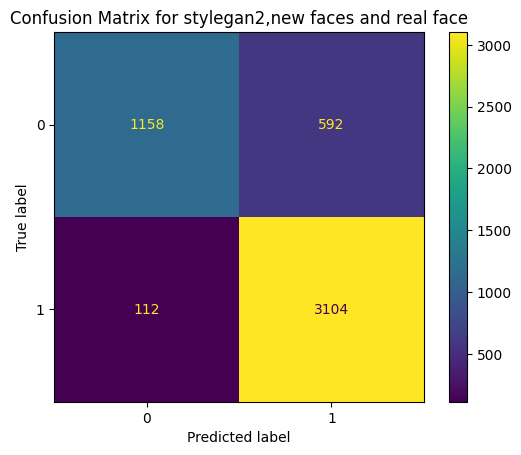


Classification Report for stylegan2,new faces and real face:
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      1750
           1       0.84      0.97      0.90      3216

    accuracy                           0.86      4966
   macro avg       0.88      0.81      0.83      4966
weighted avg       0.87      0.86      0.85      4966



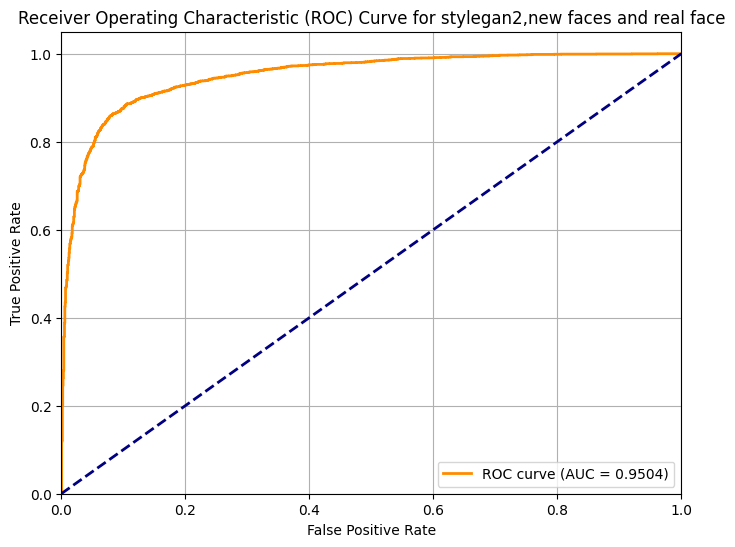

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np



# Get the true labels from the test dataset and convert to integer class labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Convert predicted probabilities to integer class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print(f"Test F1 Score for stylegan2,new faces and real face data: {f1:.4f}")

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for stylegan2,new faces and real face')
plt.show()

# Print classification report
print("\nClassification Report for stylegan2,new faces and real face:")
print(classification_report(y_true, y_pred))

# Calculate ROC curve and AUC using true one-hot encoded labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1]) # Assuming class 1 is the positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for stylegan2,new faces and real face')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Calculate TP, FP, TN, FN manually
tp = 0
fp = 0
tn = 0
fn = 0

for true_label, pred_label in zip(y_true, y_pred):
    if true_label == 1 and pred_label == 1:
        tp += 1
    elif true_label == 0 and pred_label == 1:
        fp += 1
    elif true_label == 0 and pred_label == 0:
        tn += 1
    elif true_label == 1 and pred_label == 0:
        fn += 1

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 3104
False Positives (FP): 592
True Negatives (TN): 1158
False Negatives (FN): 112


In [ ]:
stylegan3_test="/content/drive/My Drive/Research Project/dataset/Stylegan3/test.tfrecord"
test_dataset_stylegan3 = dataset_from_tfrecords([stylegan3_test,real_face_test], batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
loss_stylegan3, accuracy_stylegan3 = model.evaluate(test_dataset_stylegan3, verbose=1)


# print(f"Test Binary Accuracy: {binary_accuracy:.4f}")

# Generate predictions for the test dataset
y_pred_probs_stylegan3 = model.predict(test_dataset_stylegan3)
print(f"Test Loss: {loss_stylegan3:.4f}")
print(f"Test Accuracy: {accuracy_stylegan3:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8978 - loss: 0.3549


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
Test Loss: 0.4686
Test Accuracy: 0.8045


In [ ]:
print(y_pred_probs_stylegan3)

[[0.06423049 0.93576944]
 [0.26187274 0.73812723]
 [0.06088461 0.9391154 ]
 ...
 [0.55289036 0.44710973]
 [0.70521957 0.2947804 ]
 [0.6102848  0.38971522]]


In [ ]:
print(y_pred_probs_stylegan3.shape)
print(np.argmax(y_pred_probs_stylegan3,axis=1))

(3525, 2)
[1 1 1 ... 0 0 0]


Test F1 Score for stylegan3 and real face data: 0.8297


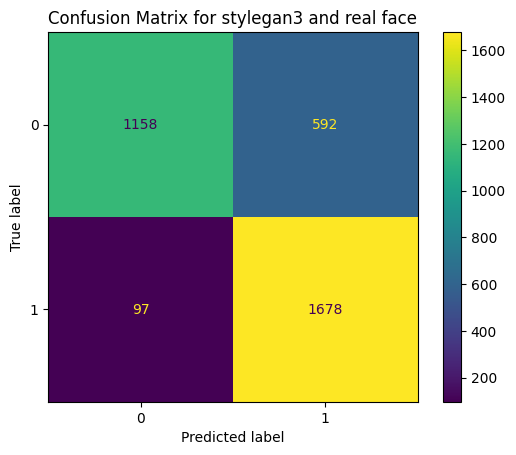


Classification Report for stylegan3 and real face:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1750
           1       0.74      0.95      0.83      1775

    accuracy                           0.80      3525
   macro avg       0.83      0.80      0.80      3525
weighted avg       0.83      0.80      0.80      3525



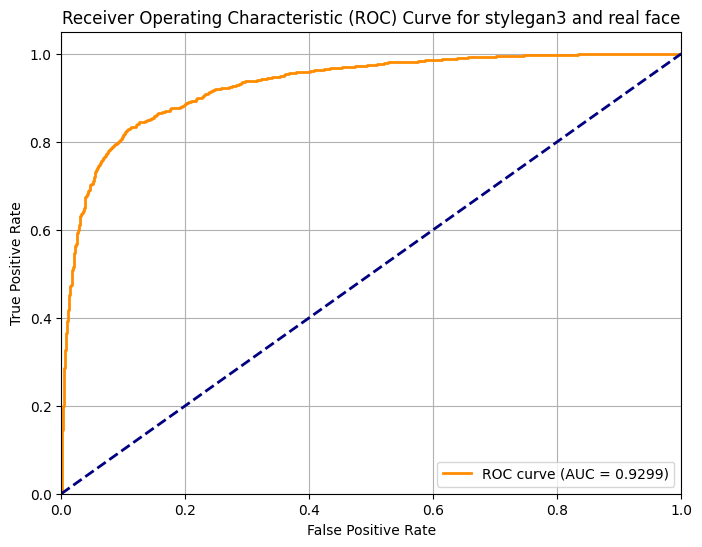

In [ ]:
# Get the true labels from the test dataset and convert to integer class labels
y_true = np.concatenate([y for x, y in test_dataset_stylegan3], axis=0)

# Convert predicted probabilities to integer class labels
y_pred = np.argmax(y_pred_probs_stylegan3, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print(f"Test F1 Score for stylegan3 and real face data: {f1:.4f}")

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for stylegan3 and real face')
plt.show()

# Print classification report
print("\nClassification Report for stylegan3 and real face:")
print(classification_report(y_true, y_pred))

# Calculate ROC curve and AUC using true one-hot encoded labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs_stylegan3[:, 1]) # Assuming class 1 is the positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for stylegan3 and real face')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
# Calculate TP, FP, TN, FN manually
tp = 0
fp = 0
tn = 0
fn = 0

for true_label, pred_label in zip(y_true, y_pred):
    if true_label == 1 and pred_label == 1:
        tp += 1
    elif true_label == 0 and pred_label == 1:
        fp += 1
    elif true_label == 0 and pred_label == 0:
        tn += 1
    elif true_label == 1 and pred_label == 0:
        fn += 1

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 1678
False Positives (FP): 592
True Negatives (TN): 1158
False Negatives (FN): 97


New faces

In [ ]:
new_faces_test="/content/drive/My Drive/Research Project/dataset/New_faces/test.tfrecord"
test_dataset_new_faces = dataset_from_tfrecords([new_faces_test,real_face_test], batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
loss_new_faces, accuracy_new_faces = model.evaluate(test_dataset_new_faces, verbose=1)


# print(f"Test Binary Accuracy: {binary_accuracy:.4f}")

# Generate predictions for the test dataset
y_pred_probs_new_faces = model.predict(test_dataset_new_faces)
print(f"Test Loss: {loss_new_faces:.4f}")
print(f"Test Accuracy: {accuracy_new_faces:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9045 - loss: 0.3147


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
Test Loss: 0.4561
Test Accuracy: 0.7988


In [ ]:
print(y_pred_probs_new_faces)

[[0.1951049  0.8048951 ]
 [0.03354966 0.96645033]
 [0.10944268 0.8905573 ]
 ...
 [0.5528905  0.44710952]
 [0.7052197  0.29478025]
 [0.61028486 0.3897151 ]]


In [ ]:
print(y_pred_probs_new_faces.shape)
print(np.argmax(y_pred_probs_new_faces,axis=1))

(3191, 2)
[1 1 1 ... 0 0 0]


Test F1 Score for new faces and real face data: 0.8125


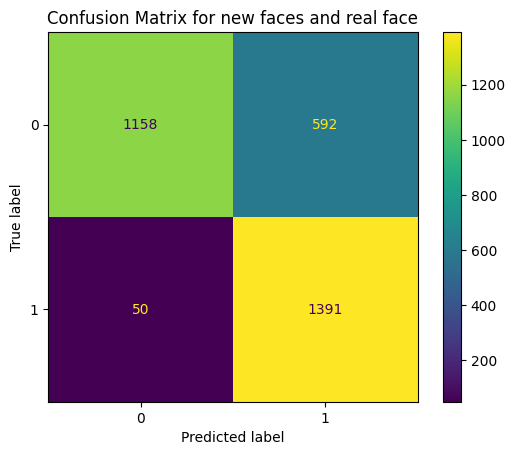


Classification Report for new faces and real face:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      1750
           1       0.70      0.97      0.81      1441

    accuracy                           0.80      3191
   macro avg       0.83      0.81      0.80      3191
weighted avg       0.84      0.80      0.80      3191



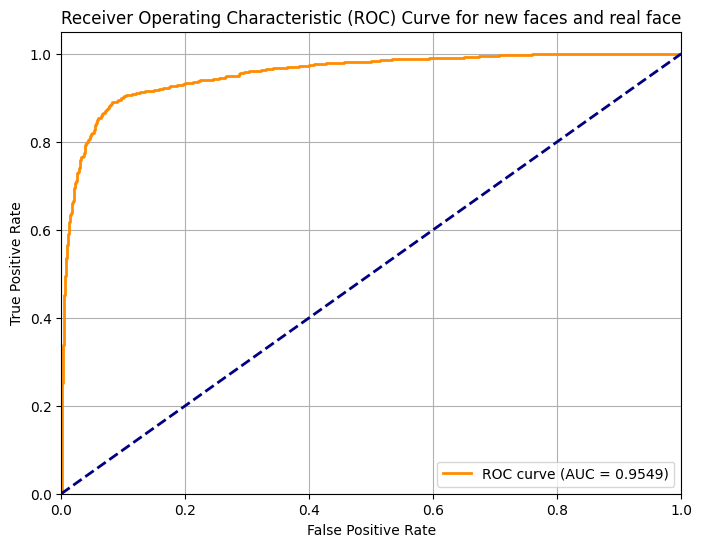

In [ ]:
# Get the true labels from the test dataset and convert to integer class labels
y_true = np.concatenate([y for x, y in test_dataset_new_faces], axis=0)

# Convert predicted probabilities to integer class labels
y_pred = np.argmax(y_pred_probs_new_faces, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print(f"Test F1 Score for new faces and real face data: {f1:.4f}")

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for new faces and real face')
plt.show()

# Print classification report
print("\nClassification Report for new faces and real face:")
print(classification_report(y_true, y_pred))

# Calculate ROC curve and AUC using true one-hot encoded labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs_new_faces[:, 1]) # Assuming class 1 is the positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for new faces and real face')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
# Calculate TP, FP, TN, FN manually
tp = 0
fp = 0
tn = 0
fn = 0

for true_label, pred_label in zip(y_true, y_pred):
    if true_label == 1 and pred_label == 1:
        tp += 1
    elif true_label == 0 and pred_label == 1:
        fp += 1
    elif true_label == 0 and pred_label == 0:
        tn += 1
    elif true_label == 1 and pred_label == 0:
        fn += 1

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 1391
False Positives (FP): 592
True Negatives (TN): 1158
False Negatives (FN): 50
